# Load Images

## Compare hrHSI and Snapshot

### Load HrHSI

In [2]:
from preprocessing import preprocessHrHSI

# Specify paths
hr_path = "data/FX10/corn_m3"
hr_mtx_path = 'calibration/hrHSI_matrix.npy'
hr_dist_path = 'calibration/hrHSI_dist.npy'

# Load and preprocess file
hr_file = preprocessHrHSI(hr_path + ".hdf5", hr_mtx_path, hr_dist_path)
hr_img = hr_file[0]
hr_wavelengths = hr_file[1]

In [ ]:
# Preview hrHSI
from preprocessing import previewHrHSI
previewHrHSI(hr_img, hr_wavelengths, 
             selected_pixel=(500, 500),
             selected_spectrum=200)

### Load Snapshot

In [4]:
from preprocessing import preprocessSnapshot

# Specify paths
ss_path = "data/Snapshot/processed/train/corn_m3/"
ss_mtx_path = 'calibration/snapshot_matrix.npy'
ss_dist_path = 'calibration/snapshot_dist.npy'

# Load and preprocess file
ss_file = preprocessSnapshot(ss_path, ss_mtx_path, ss_dist_path)
ss_img = ss_file[0]
ss_wavelengths = ss_file[1]

In [ ]:
# Preview snapshot
from preprocessing import previewSnapshot
previewSnapshot(ss_img, ss_wavelengths, 
                 selected_pixel=(100, 150),
                 selected_spectrum=12)

### Compare images

In [ ]:
from align_images import align_images, plot_image_comparison

# Set offsets and rotations
hr_x_off = (106, 1018)   # Full: (0, 1084) # Previous: (104, 1019)
hr_y_off = (189, 720)   # Full: (0, 1015) # Previous: (189, 720)
# rot = -0.2
# shear = 0.017
rot = 0
shear = 0

ss_x_off = (3, 402)
ss_y_off = (2, 212)


# Align images
hr_img_al, ss_img_al = align_images(hr_img=hr_img,
                                    ss_img=ss_img, 
                                    ss_x_off=ss_x_off,
                                    ss_y_off=ss_y_off,
                                    hr_x_off=hr_x_off, 
                                    hr_y_off=hr_y_off,
                                    rot=rot,
                                    shear=shear)




# Plot image comparison
plot_image_comparison(hr_img=hr_img_al, 
                      hr_wavelengths=hr_wavelengths, 
                      ss_img=ss_img_al, 
                      ss_wavelengths=ss_wavelengths, 
                      selected_pixel=(115, 220),
                      selected_spectrum=715)

## Compare aspect ratios

In [ ]:
# Compare resolutions
print("HrHSI:", hr_img_al.shape)
print("Shapshot:", ss_img_al.shape)
print("\n")

# Compare aspect ratio
print("HrHSI:", round(hr_img_al.shape[1] / hr_img_al.shape[0], 6))
print("Shapshot:", round(ss_img_al.shape[1] / ss_img_al.shape[0], 6))

# Difference between aspect ratios
print("Difference:", round((hr_img_al.shape[1] / hr_img_al.shape[0]) - (ss_img_al.shape[1] / ss_img_al.shape[0]), 6))

# Compare Fully Processed Images

### Load hrHSI and go through full preprocessing pipeline

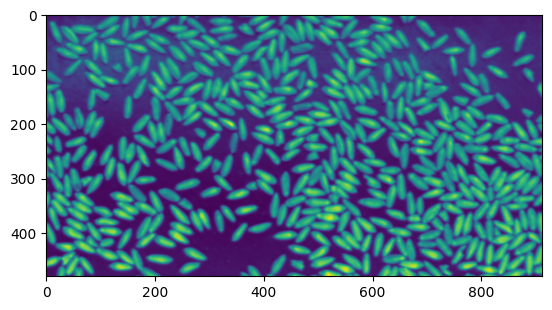

In [2]:
from preprocessing import preprocessFullHSI
import matplotlib.pyplot as plt

# Specify paths
hr_path = 'data/FX10/spelt_s3.hdf5'
hr_mtx_path = 'calibration/hrHSI_matrix.npy'
hr_dist_path = 'calibration/hrHSI_dist.npy'

# Snapshot dimensions and wavelengths
ss_shape = (210, 399, 24)
ss_wavelengths = [667, 679, 691, 703, 715, 
                  727, 739, 751, 763, 775, 
                  787, 799, 811, 823, 835, 
                  847, 859, 871, 883, 895, 
                  907, 919, 931, 943]


# Set offsets and rotations
hr_x_off = (106, 1018)   # Full: (0, 1084)
hr_y_off = (189, 720)    # Full: (0, 1015)
rot = -0.2
shear = 0.017

# Load and preprocess file
hr_file = preprocessFullHSI(path_to_hdf5=hr_path, 
                            mtx_path=hr_mtx_path, 
                            dist_path=hr_dist_path, 
                            hr_x_off=hr_x_off, 
                            hr_y_off=hr_y_off, 
                            rot=rot, 
                            shear=shear, 
                            ss_shape=ss_shape, 
                            ss_wavelengths=ss_wavelengths)
hr_img = hr_file[0]
hr_wavelengths = hr_file[1]

# Display image
plt.imshow(hr_img[:, :, 3])
plt.show()

### Load snapshot

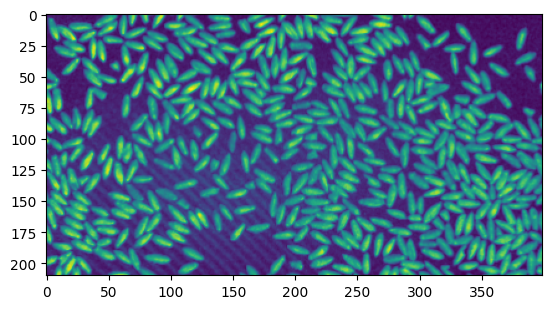

In [3]:
from preprocessing import preprocessSnapshot
import matplotlib.pyplot as plt

# Specify paths
ss_path = "data/Snapshot/processed/train/spelt_s3/"
ss_mtx_path = 'calibration/snapshot_matrix.npy'
ss_dist_path = 'calibration/snapshot_dist.npy'

# Load and preprocess file
ss_x_off = (3, 402)
ss_y_off = (2, 212)

ss_file = preprocessSnapshot(ss_path, ss_mtx_path, ss_dist_path, ss_x_off, ss_y_off)

# Store to variables
ss_img = ss_file[0]
ss_wavelengths = ss_file[1]


plt.imshow(ss_img[:, :, 3])
plt.show()

### Show side by side comparison

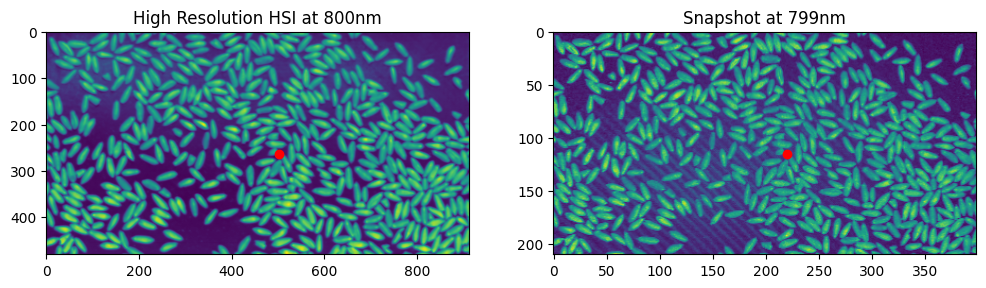

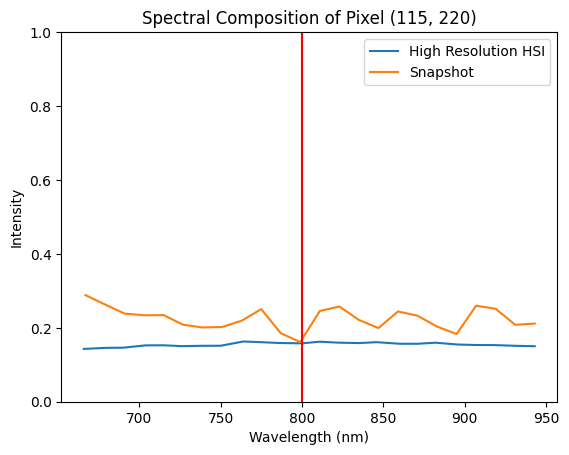

In [4]:
from align_images import plot_image_comparison

# Plot image comparison
plot_image_comparison(hr_img=hr_img, 
                      hr_wavelengths=hr_wavelengths, 
                      ss_img=ss_img, 
                      ss_wavelengths=ss_wavelengths, 
                      selected_pixel=(115, 220),
                      selected_spectrum=800)

In [5]:
print(ss_img.shape)
print(hr_img.shape)

# Print aspect ratio
print("HrHSI:", round(hr_img.shape[1] / hr_img.shape[0], 6))
print("Shapshot:", round(ss_img.shape[1] / ss_img.shape[0], 6))

(210, 399, 24)
(480, 912, 24)
HrHSI: 1.9
Shapshot: 1.9


# Compare fully-processed files

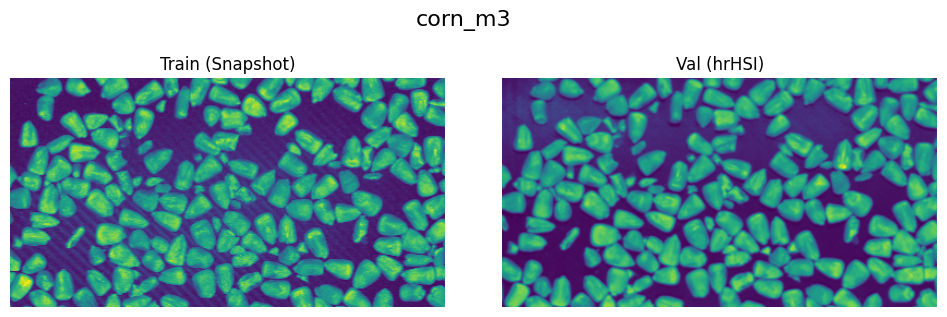

Train: 1.9
Val: 1.9
Train: (210, 399, 24)
Val: (480, 912, 24)


In [11]:
import numpy as np

# List of all grains
grains = ["spelt", "rye", "flax", "wheatgrass", "pumpkin", "sunflower", 
          "flaxb", "buckwheat", "millet", "barley", "mix", "corn"]

# Select image
image_id = "corn_m3"

train_img = np.load("data/Processed/train/" + image_id + ".npy")
val_img = np.load("data/Processed/val/" + image_id + ".npy")


# Plot images next to each other
import matplotlib.pyplot as plt

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.tight_layout()
fig.suptitle(image_id, fontsize=16)
axs[0].axis('off')
axs[1].axis('off')
axs[0].imshow(train_img[:, :, 10])
axs[1].imshow(val_img[:, :, 10])
axs[0].set_title("Train (Snapshot)")
axs[1].set_title("Val (hrHSI)")
plt.show()


# Save as b&w image
import cv2 as cv
cv.imwrite("data/Processed/images/" + image_id + "_train.jpg", train_img[:, :, 10] * 255)
cv.imwrite("data/Processed/images/" + image_id + "_val.jpg", val_img[:, :, 10] * 255)

# Print aspect ratios
print("Train:", round(train_img.shape[1] / train_img.shape[0], 6))
print("Val:", round(val_img.shape[1] / val_img.shape[0], 6))

# Print shapes
print("Train:", train_img.shape)
print("Val:", val_img.shape)

# Loop over all images to check for corruption

In [12]:
import numpy as np
import cv2 as cv

# List of all grains
grains = ["spelt", "rye", "flax", "wheatgrass", "pumpkin", "sunflower", 
          "flaxb", "buckwheat", "millet", "barley", "mix", "corn"]
densities = ["s", "m", "l"]
img_nos = [0, 1, 2, 3, 4]


for f in grains:
    for d in densities:
        for i in img_nos:
            image_id = f + "_" + d + str(i)
            train_img = np.load("data/Processed/train/" + image_id + ".npy")
            val_img = np.load("data/Processed/val/" + image_id + ".npy")
            cv.imwrite("data/Processed/images/" + image_id + "_train.jpg", train_img[:, :, 10] * 255)
            cv.imwrite("data/Processed/images/" + image_id + "_val.jpg", val_img[:, :, 10] * 255)

In [13]:
# Load processed validation image
val_img = np.load("data/Processed/val/barley_m3.npy")
print("val: ", val_img.shape)

# Load processed training image
train_img = np.load("data/Processed/train/corn_m3.npy")
print("train: ", train_img.shape)

val:  (480, 912, 24)
train:  (210, 399, 24)


In [15]:
print(train_img.min())

0.036823153
